In [77]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload 
import qutip as qt
from scipy.optimize import curve_fit, minimize

# %matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
reload(sq_ext)
reload(sq)
reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

<Figure size 640x480 with 0 Axes>

In [78]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

## Fluxonium qutrit vs $\phi_{ext}$

In [79]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

In [90]:
nmax_f=20
reload(sq_ext)

fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, L_F_eff =L_F_eff, Δ=Δ, φ_ext=0.5, nmax_f=nmax_f)
H_0  = fluxonium.hamiltonian()
E_0, ψ_0 = sq_ext.diag(H_0, 3, solver='numpy', qObj=True, remove_ground=True)

In [91]:
φ_ext_values                = np.linspace(0.5, 1, 100)
E_vs_φ_ext                  = np.zeros([len(φ_ext_values), 3])
H_eff_SWT_decomp_vs_φ_ext   = np.zeros([len(φ_ext_values), 4])
ω_qo_vs_φ_ext               = np.zeros([len(φ_ext_values), 3])

In [92]:
loop = fluxonium.loops[0]
for i, φ_ext  in enumerate(φ_ext_values):
    loop.set_flux(φ_ext)
    H = fluxonium.hamiltonian()
    E_vs_φ_ext[i], ψ = sq_ext.diag(H, 3, solver='numpy', qObj=True, remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E_vs_φ_ext[i])
    H_eff_SWT_decomp_vs_φ_ext[i]  = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False, test_decomposition=True)
    
    if i==0:
        break

labels_H_eff_SWT_decomp = sq_ext.decomposition_in_pauli_3x3(H_eff_SWT, print_pretty=False, return_labels=True)[1]   

LinAlgError: Singular matrix

In [86]:
H_eff_SWT

array([[0.        +0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 3.68869788+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 8.09475116+0.j]])

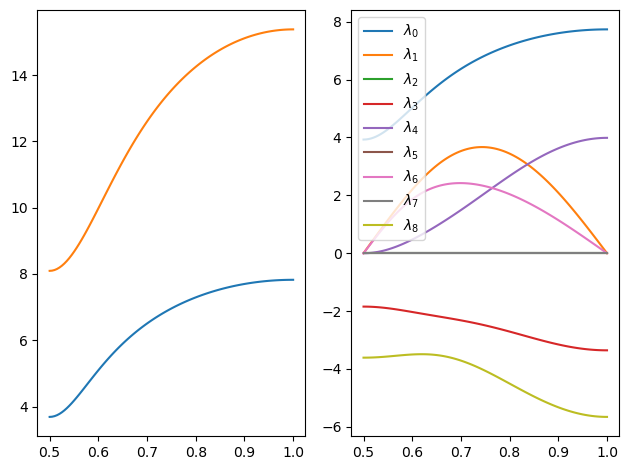

In [76]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.plot(φ_ext_values, E_vs_φ_ext[:,1:])
ax2.plot(φ_ext_values, H_eff_SWT_decomp_vs_φ_ext, label=labels_H_eff_SWT_decomp)
ax2.legend()
fig.tight_layout()